# Build and Test our Datamodule

This is where we will create our Datamodule.
This is a PyTorch Lightning module that will include the Dataset and Dataloader objects from vanilla PyTorch.

In this file and the LightningModule one [next](1.2-verify_lightningmodule.ipynb), we will hardcode many values, such as the data paths and also the hyperparameters (batch size, etc.).
In the real Python source files (`.py`) in the 'src/` folder, we will make use of the wonderful Hydra configuration management library to control these values.

In [1]:
import rootutils
import os
root = rootutils.setup_root(search_from=os.getcwd(), indicator=".project-root", dotenv=True, pythonpath=True, cwd=True)

In [2]:
import lightning as L
from monai import utils, transforms, networks, data, engines, losses, metrics, visualize, config, inferers, apps
from monai.data import CacheDataset, DataLoader, list_data_collate, pad_list_data_collate, decollate_batch
import torch
import matplotlib.pyplot as plt
# make sure you have numpy=1.26.0 bc of a bug between newer numpy and monai at the time of this writing. Will surely be solved by monai team in future.
import numpy as np
import pandas as pd
import glob
import os
import shutil
import tempfile
import rootutils

In [3]:
class SpleenDatamodule(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 2,
        num_workers: int = 4,
        pin_memory: bool = False,
    ) -> None:
        super().__init__()
        # this below line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        # self.batch_size = batch_size
        # self.num_workers = num_workers

    def prepare_data(self):
        # download, split, etc...
        # only called on 1 GPU/TPU in distributed
        # we already downloaded our data so we will not do anything here
        pass

    def setup(self, stage=None):
        # the stage is 'fit', 'validate', 'test', or 'predict'

        # We first need to define the transforms that we will apply to the data
        # Transforms may sound like they just augment the data, but they can also be used to preprocess the data, including loading the data and converting it to the correct format
        self.train_transforms = transforms.Compose(
            [
                transforms.LoadImaged(keys=["image", "label"]),
                transforms.EnsureChannelFirstd(keys=["image", "label"]),
                transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
                transforms.Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
                transforms.ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
                transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
                # transforms.EnsureTyped(keys=["image", "label"]),
                transforms.RandCropByPosNegLabeld(keys=["image", "label"], label_key="label", spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4),
            ]
        )

        self.val_transforms = transforms.Compose(
            [
                transforms.LoadImaged(keys=["image", "label"]),
                transforms.EnsureChannelFirstd(keys=["image", "label"]),
                transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
                transforms.Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
                transforms.ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
                transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
                # transforms.EnsureTyped(keys=["image", "label"]),
            ]
        )
        
        self.test_transforms = transforms.Compose(
            [
                transforms.LoadImaged(keys=["image", "label"]),
                transforms.EnsureChannelFirstd(keys=["image", "label"]),
                transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
                transforms.Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
                transforms.ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
                transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
                # transforms.EnsureTyped(keys=["image", "label"]),
            ]
        )

        # make assignments here (val/train/test split)
        # called on every process in DDP
        # TODO: os.path.join() is not working???
        # IMAGE_SRC = os.path.join(root,"/data/Task09_Spleen/imagesTr")
        IMAGE_SRC = str(root) + "/data/Task09_Spleen/imagesTr"
        # LABEL_SRC = os.path.join(root,"/data/Task09_Spleen/labelsTr")
        LABEL_SRC = str(root) + "/data/Task09_Spleen/labelsTr"
        SPLIT_NAME = "MySplit"
        # this can be done by stage
        # filenames = None
        # if stage == "fit":
        #     filenames = pd.read_csv(f"/splits/{SPLIT_NAME}/train_{SPLIT_NAME}.csv")
        #     # Create a dictionary list of the image and label files labelled as 'image' and 'label'
        #     self.train_files = [{"image": os.path.join(IMAGE_SRC, f"{filename}.nii.gz"), "label": os.path.join(LABEL_SRC, f"{filename}.nii.gz")} for filename in filenames]
        #     self.train_ds = CacheDataset(data=self.train_files, transform=self.train_transforms, cache_rate=1.0, num_workers=self.num_workers)
        # elif stage == "validate":
        #     filenames = pd.read_csv(f"/splits/{SPLIT_NAME}/val_{SPLIT_NAME}.csv")
        #     self.val_files = [{"image": os.path.join(IMAGE_SRC, f"{filename}.nii.gz"), "label": os.path.join(LABEL_SRC, f"{filename}.nii.gz")} for filename in filenames]
        #     self.val_ds = CacheDataset(data=self.val_files, transform=self.val_transforms, cache_rate=1.0, num_workers=self.num_workers)
        # elif stage == "test":
        #     filenames = pd.read_csv(f"/splits/{SPLIT_NAME}/test_{SPLIT_NAME}.csv")
        #     self.test_files = [{"image": os.path.join(IMAGE_SRC, f"{filename}.nii.gz"), "label": os.path.join(LABEL_SRC, f"{filename}.nii.gz")} for filename in filenames]
        #     self.test_ds = CacheDataset(data=self.test_files, transform=self.test_transforms, cache_rate=1.0, num_workers=self.num_workers)
        # else:
        #     raise ValueError(f"Stage {stage} not supported")

        # TODO: os.path.join() is not working for some reason
        # train_csv = os.path.join(str(root),f"/splits/{SPLIT_NAME}/train_{SPLIT_NAME}.csv")
        train_csv = f"/splits/{SPLIT_NAME}/train_{SPLIT_NAME}.csv"
        # train_csv = os.path.join(str(root), train_csv)
        train_csv = str(root) + train_csv
        train_filenames = pd.read_csv(train_csv)
        self.train_files = [{"image": os.path.join(IMAGE_SRC, row["image"]), "label": os.path.join(LABEL_SRC, row["label"])} for index, row in train_filenames.iterrows()]
        self.train_files = self.train_files[:2]       # for testing purposes
        self.train_ds = CacheDataset(data=self.train_files, transform=self.train_transforms, cache_rate=1.0, num_workers=self.hparams.num_workers)
        
        val_csv = f"/splits/{SPLIT_NAME}/val_{SPLIT_NAME}.csv"
        val_csv = str(root) + val_csv
        val_filenames = pd.read_csv(val_csv)
        self.val_files = [{"image": os.path.join(IMAGE_SRC, row["image"]), "label": os.path.join(LABEL_SRC, row["label"])} for index, row in val_filenames.iterrows()]
        self.val_files = self.val_files[:2]       # for testing purposes
        self.val_ds = CacheDataset(data=self.val_files, transform=self.val_transforms, cache_rate=1.0, num_workers=self.hparams.num_workers)
        
        test_csv = f"/splits/{SPLIT_NAME}/test_{SPLIT_NAME}.csv"
        test_csv = str(root) + test_csv
        test_filenames = pd.read_csv(test_csv)
        self.test_files = [{"image": os.path.join(IMAGE_SRC, row["image"]), "label": os.path.join(LABEL_SRC, row["label"])} for index, row in test_filenames.iterrows()]
        self.test_files = self.test_files[:2]       # for testing purposes
        self.test_ds = CacheDataset(data=self.test_files, transform=self.test_transforms, cache_rate=1.0, num_workers=self.hparams.num_workers)
        


    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_ds,
            batch_size=self.hparams.batch_size,         # we can use this nifty trick and access the hyperparameters directly since we used self.save_hyperparameters() up top
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=list_data_collate,               # this collates our list of dictionaries into a dictionary of lists; not needed for if your dataset outputs something the default collate_fn can handle
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_ds,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=pad_list_data_collate,
            shuffle=False,
        )
    
    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_ds,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=list_data_collate,
            shuffle=False,
        )

In [4]:
import lightning as L
from monai import utils, transforms, networks, data, engines, losses, metrics, visualize, config, inferers, apps
from monai.data import CacheDataset, DataLoader, list_data_collate, pad_list_data_collate, decollate_batch
import torch
import matplotlib.pyplot as plt
# make sure you have numpy=1.26.0 bc of a bug between newer numpy and monai at the time of this writing. Will surely be solved by monai team in future.
import numpy as np
import pandas as pd
import glob
import os
import shutil
import tempfile
import rootutils

In [5]:
datamodule = SpleenDatamodule()


In [6]:
datamodule.setup()

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
Loading dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Okay, now let's print out some images and labels to take a look at the data.

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


dict_keys(['image', 'label', 'foreground_start_coord', 'foreground_end_coord'])
torch.Size([2, 1, 272, 264, 223]) torch.Size([2, 1, 272, 264, 223])
(array([39, 39, 39, ..., 98, 98, 98]), array([119, 119, 119, ..., 105, 105, 105]), array([31, 32, 33, ..., 60, 61, 62]))


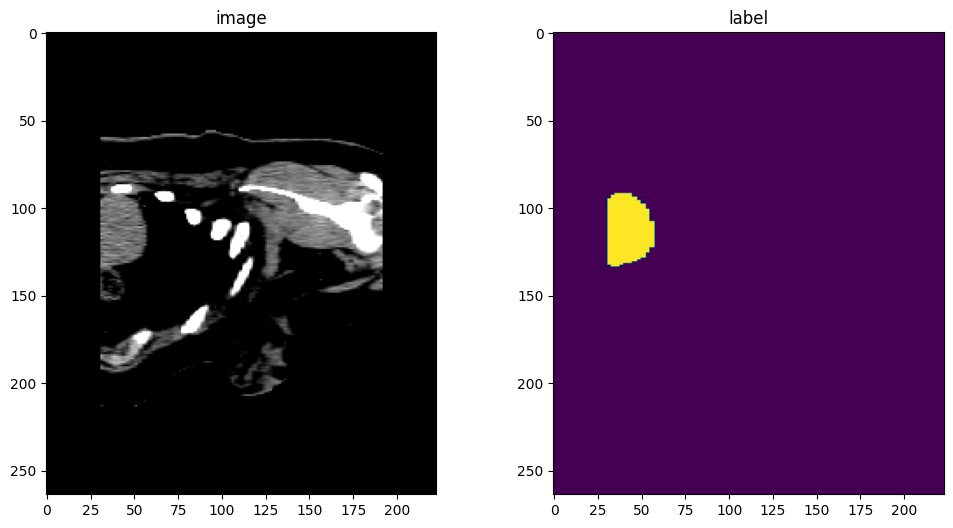

In [7]:
# let's get the train dataloader and check the first batch
train_dl = datamodule.val_dataloader()
batch = next(iter(train_dl))
# print the keys of batch
print(batch.keys())
images, labels = (batch["image"], batch["label"])
print(images.shape, labels.shape)

# find the non-zero slice indices of labels within labels[0,0,100,:,:] if they exist
non_zero_indices = np.where(labels[0, 0, :, :, :])
print(non_zero_indices)

# let's print a cross section using the first image and label and matplotlib
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(images[0, 0, 50, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(labels[0, 0, 50, :, :])

It's plotting!

Good enough for now